In [1]:
import numpy as np
import pandas as pd

import missingno as msno 
import string 
import seaborn as sns 
import matplotlib.pyplot as plt

import scipy.optimize as opt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import scipy.stats as sps
from matplotlib_venn import venn3
from supervenn import supervenn
import json
import csv

import re    # for regular expressions 
import string

import glob, os
from epss_api import EPSS

In [2]:
csv.field_size_limit(100000000)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
kev = pd.read_csv('kev.csv', encoding = 'utf-8-sig', engine = 'python')

In [4]:
kev.head(1)

,cveID,vendorProject,product,vulnerabilityName,dateAdded,shortDescription,requiredAction,dueDate,knownRansomwareCampaignUse,notes
0,CVE-2021-27104,Accellion,FTA,Accellion FTA OS Command Injection Vulnerability,2021-11-03,Accellion FTA contains an OS command injection...,Apply updates per vendor instructions.,2021-11-17,Known,NaN


In [5]:
kev['hasKEV'] = kev['cveID'].apply(lambda x : 1)

In [6]:
kev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   cveID                       1025 non-null   object
 1   vendorProject               1025 non-null   object
 2   product                     1024 non-null   object
 3   vulnerabilityName           1025 non-null   object
 4   dateAdded                   1025 non-null   object
 5   shortDescription            1025 non-null   object
 6   requiredAction              1025 non-null   object
 7   dueDate                     1025 non-null   object
 8   knownRansomwareCampaignUse  1025 non-null   object
 9   notes                       258 non-null    object
 10  hasKEV                      1025 non-null   int64 
dtypes: int64(1), object(10)
memory usage: 88.2+ KB


In [7]:
client = EPSS()
values = client.scores()

In [8]:
cve = pd.read_csv('allitems.csv', encoding = 'utf-8-sig', engine = 'python')

In [9]:
cve.head()

,Name,Status,Description,References,Phase,Votes,Comments
0,CVE-1999-0001,Candidate,ip_input.c in BSD-derived TCP/IP implementatio...,BUGTRAQ:19981223 Re: CERT Advisory CA-98.13 - ...,Modified (20051217),"MODIFY(1) Frech | NOOP(2) Northcutt, Wall...",Christey> A Bugtraq posting indicates that the...
1,CVE-1999-0002,Entry,Buffer overflow in NFS mountd gives root acces...,BID:121 | URL:http://www.securityfocus.com...,NaN,NaN,NaN
2,CVE-1999-0003,Entry,Execute commands as root via buffer overflow i...,BID:122 | URL:http://www.securityfocus.com...,NaN,NaN,NaN
3,CVE-1999-0004,Candidate,"MIME buffer overflow in email clients, e.g. So...",CERT:CA-98.10.mime_buffer_overflows | MS:M...,Modified (19990621),"ACCEPT(8) Baker, Cole, Collins, Dik, Landfield...","Frech> Extremely minor, but I believe e-mail i..."
4,CVE-1999-0005,Entry,Arbitrary command execution via IMAP buffer ov...,BID:130 | URL:http://www.securityfocus.com...,NaN,NaN,NaN


In [10]:
candidates = cve[cve.Status == 'Candidate']

In [11]:
# remove candidates
cve = cve[cve.Status == 'Entry']

In [12]:
# df['epssScore'] = df['cveID'].apply(lambda x : client.score(cve_id=x))
epss = pd.read_csv('latest-epss-scores.csv', encoding = 'utf-8-sig', engine = 'python')

In [13]:
epss.head(1)

,cve,epss,percentile
0,CVE-2014-0160,0.97588,1.0


In [14]:
def get_files_from_path(path: str='.', extension: str=None) -> list:
    """return list of files from path"""
    # https://stackoverflow.com/a/41447012/9267296
    result = []
    for subdir, dirs, files in os.walk(path):
        for filename in files:
            filepath = subdir + os.sep + filename
            if extension == None:
                result.append(filepath)
            elif filename.lower().endswith(extension.lower()):
                result.append(filepath)
    return result

In [15]:
cvss = pd.DataFrame()

In [16]:
filelist = get_files_from_path(extension='.json')
alldata = []
for filepath in filelist:
    with open(filepath) as infile:
#         jsonlist.append(json.load(infile))
        data = json.load(infile)
#         alldata.append(data)
        df = pd.DataFrame(data)
        df = pd.json_normalize(df["CVE_Items"])
        cvss = cvss.append(df,ignore_index=True)

In [19]:
cvss.tail(10)

,publishedDate,lastModifiedDate,cve.data_type,cve.data_format,cve.data_version,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,cve.problemtype.problemtype_data,cve.references.reference_data,cve.description.description_data,...,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.severity,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.acInsufInfo,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.userInteractionRequired
229443,2023-05-22T22:15Z,2023-05-30T18:05Z,CVE,MITRE,4.0,CVE-2022-4945,ics-cert@hq.dhs.gov,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://dataprobe.com/support/iboot-...,"[{'lang': 'en', 'value': 'The Dataprobe cloud ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229444,2023-06-05T14:15Z,2023-06-13T13:53Z,CVE,MITRE,4.0,CVE-2022-4946,contact@wpscan.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://wpscan.com/vulnerability/6e2...,"[{'lang': 'en', 'value': 'The Frontend Post Wo...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229445,2023-06-07T02:15Z,2023-06-13T18:38Z,CVE,MITRE,4.0,CVE-2022-4948,cve-request@wordfence.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.wordfence.com/threat-int...,"[{'lang': 'en', 'value': 'The FlyingPress plug...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229446,2023-06-07T02:15Z,2023-06-13T18:40Z,CVE,MITRE,4.0,CVE-2022-4949,cve-request@wordfence.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://blog.nintechnet.com/critical...,"[{'lang': 'en', 'value': 'The AdSanity plugin ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229447,2023-06-07T02:15Z,2023-06-13T18:42Z,CVE,MITRE,4.0,CVE-2022-4950,cve-request@wordfence.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.wordfence.com/threat-int...,"[{'lang': 'en', 'value': 'Several WordPress pl...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229448,2023-07-17T02:15Z,2023-07-27T04:07Z,CVE,MITRE,4.0,CVE-2022-4952,cna@vuldb.com,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'https://github.com/OmniSharp/csharp-...,"[{'lang': 'en', 'value': 'A vulnerability has ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229449,2023-08-14T20:15Z,2023-09-08T23:15Z,CVE,MITRE,4.0,CVE-2022-4953,contact@wpscan.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://wpscan.com/vulnerability/827...,"[{'lang': 'en', 'value': 'The Elementor Websit...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229450,2023-10-20T07:15Z,2023-10-26T17:28Z,CVE,MITRE,4.0,CVE-2022-4954,cve-request@wordfence.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.wordfence.com/threat-int...,"[{'lang': 'en', 'value': 'The Waiting: One-cli...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229451,2023-08-04T20:15Z,2023-08-09T17:19Z,CVE,MITRE,4.0,CVE-2022-4955,chrome-cve-admin@google.com,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'https://chromereleases.googleblog.co...,"[{'lang': 'en', 'value': 'Inappropriate implem...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229452,2023-09-30T17:15Z,2023-10-03T20:58Z,CVE,MITRE,4.0,CVE-2022-4956,cna@vuldb.com,"[{'description': [{'lang': 'en', 'value': 'CWE...","[{'url': 'https://vuldb.com/?id.240903', 'name...","[{'lang': 'en', 'value': 'A vulnerability clas...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
cvss.head(10)

,publishedDate,lastModifiedDate,cve.data_type,cve.data_format,cve.data_version,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,cve.problemtype.problemtype_data,cve.references.reference_data,cve.description.description_data,...,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.severity,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.acInsufInfo,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.userInteractionRequired
0,2021-06-09T20:15Z,2021-06-28T18:03Z,CVE,MITRE,4.0,CVE-2021-0001,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Observable timing di...",...,NONE,2.1,LOW,3.9,2.9,False,False,False,False,False
1,2021-08-11T13:15Z,2021-11-30T19:43Z,CVE,MITRE,4.0,CVE-2021-0002,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Improper conditions ...",...,PARTIAL,3.6,LOW,3.9,4.9,False,False,False,False,False
2,2021-08-11T13:15Z,2021-09-14T18:36Z,CVE,MITRE,4.0,CVE-2021-0003,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Improper conditions ...",...,NONE,2.1,LOW,3.9,2.9,False,False,False,False,False
3,2021-08-11T13:15Z,2022-03-31T19:45Z,CVE,MITRE,4.0,CVE-2021-0004,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Improper buffer rest...",...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
4,2021-08-11T13:15Z,2021-09-14T18:36Z,CVE,MITRE,4.0,CVE-2021-0005,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Uncaught exception i...",...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
5,2021-08-11T13:15Z,2021-09-14T18:35Z,CVE,MITRE,4.0,CVE-2021-0006,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Improper conditions ...",...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
6,2021-08-11T13:15Z,2021-09-14T18:35Z,CVE,MITRE,4.0,CVE-2021-0007,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Uncaught exception i...",...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
7,2021-08-11T13:15Z,2021-09-14T18:34Z,CVE,MITRE,4.0,CVE-2021-0008,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Uncontrolled resourc...",...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
8,2021-08-11T13:15Z,2021-09-14T18:34Z,CVE,MITRE,4.0,CVE-2021-0009,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Out-of-bounds read i...",...,NONE,3.3,LOW,6.5,2.9,False,False,False,False,False
9,2023-05-16T22:15Z,2023-05-16T22:15Z,CVE,MITRE,4.0,CVE-2021-0010,cve@mitre.org,[{'description': []}],[],"[{'lang': 'en', 'value': '** REJECT ** DO NOT ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
cvss = cvss.infer_objects()

In [22]:
cvss.lastModifiedDate = pd.to_datetime(cvss.lastModifiedDate)
cvss.publishedDate = pd.to_datetime(cvss.publishedDate)

In [23]:
# remove columns with high cardinality 
drop_these = ['cve.data_version', 'cve.data_type', 'cve.data_format', 'cve.references.reference_data', 'cve.problemtype.problemtype_data', 'cve.description.description_data', 'configurations.CVE_data_version']
cvss = cvss.drop(columns=drop_these)

In [24]:
cvss.tail(10)

,publishedDate,lastModifiedDate,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,configurations.nodes,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.privilegesRequired,...,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.severity,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.acInsufInfo,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.userInteractionRequired
229443,2023-05-22 22:15:00+00:00,2023-05-30 18:05:00+00:00,CVE-2022-4945,ics-cert@hq.dhs.gov,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:C/C:H/I:N/A:N,LOCAL,LOW,LOW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229444,2023-06-05 14:15:00+00:00,2023-06-13 13:53:00+00:00,CVE-2022-4946,contact@wpscan.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,LOW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229445,2023-06-07 02:15:00+00:00,2023-06-13 18:38:00+00:00,CVE-2022-4948,cve-request@wordfence.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:N/I:L/A:N,NETWORK,LOW,LOW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229446,2023-06-07 02:15:00+00:00,2023-06-13 18:40:00+00:00,CVE-2022-4949,cve-request@wordfence.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,LOW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229447,2023-06-07 02:15:00+00:00,2023-06-13 18:42:00+00:00,CVE-2022-4950,cve-request@wordfence.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,LOW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229448,2023-07-17 02:15:00+00:00,2023-07-27 04:07:00+00:00,CVE-2022-4952,cna@vuldb.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,NETWORK,LOW,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229449,2023-08-14 20:15:00+00:00,2023-09-08 23:15:00+00:00,CVE-2022-4953,contact@wpscan.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229450,2023-10-20 07:15:00+00:00,2023-10-26 17:28:00+00:00,CVE-2022-4954,cve-request@wordfence.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:H/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,HIGH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229451,2023-08-04 20:15:00+00:00,2023-08-09 17:19:00+00:00,CVE-2022-4955,chrome-cve-admin@google.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:H/A:N,NETWORK,LOW,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229452,2023-09-30 17:15:00+00:00,2023-10-03 20:58:00+00:00,CVE-2022-4956,cna@vuldb.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,LOCAL,LOW,LOW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# might have to remove them later on though
cvss['impact.baseMetricV3.cvssV3.baseScore'].fillna(0, inplace=True)
cvss['impact.baseMetricV2.cvssV2.baseScore'].fillna(0, inplace=True)

In [26]:
cvss.head(10)

,publishedDate,lastModifiedDate,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,configurations.nodes,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.privilegesRequired,...,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.severity,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.acInsufInfo,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.userInteractionRequired
0,2021-06-09 20:15:00+00:00,2021-06-28 18:03:00+00:00,CVE-2021-0001,secure@intel.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:H/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,HIGH,LOW,...,NONE,2.1,LOW,3.9,2.9,False,False,False,False,False
1,2021-08-11 13:15:00+00:00,2021-11-30 19:43:00+00:00,CVE-2021-0002,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:H,LOCAL,LOW,LOW,...,PARTIAL,3.6,LOW,3.9,4.9,False,False,False,False,False
2,2021-08-11 13:15:00+00:00,2021-09-14 18:36:00+00:00,CVE-2021-0003,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,LOW,LOW,...,NONE,2.1,LOW,3.9,2.9,False,False,False,False,False
3,2021-08-11 13:15:00+00:00,2022-03-31 19:45:00+00:00,CVE-2021-0004,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,LOCAL,LOW,HIGH,...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
4,2021-08-11 13:15:00+00:00,2021-09-14 18:36:00+00:00,CVE-2021-0005,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,LOCAL,LOW,HIGH,...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
5,2021-08-11 13:15:00+00:00,2021-09-14 18:35:00+00:00,CVE-2021-0006,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,LOCAL,LOW,HIGH,...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
6,2021-08-11 13:15:00+00:00,2021-09-14 18:35:00+00:00,CVE-2021-0007,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,LOCAL,LOW,HIGH,...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
7,2021-08-11 13:15:00+00:00,2021-09-14 18:34:00+00:00,CVE-2021-0008,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,LOCAL,LOW,HIGH,...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
8,2021-08-11 13:15:00+00:00,2021-09-14 18:34:00+00:00,CVE-2021-0009,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:A/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,ADJACENT_NETWORK,LOW,NONE,...,NONE,3.3,LOW,6.5,2.9,False,False,False,False,False
9,2023-05-16 22:15:00+00:00,2023-05-16 22:15:00+00:00,CVE-2021-0010,cve@mitre.org,[],NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
cvss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229453 entries, 0 to 229452
Data columns (total 36 columns):
 #   Column                                            Non-Null Count   Dtype              
---  ------                                            --------------   -----              
 0   publishedDate                                     229453 non-null  datetime64[ns, UTC]
 1   lastModifiedDate                                  229453 non-null  datetime64[ns, UTC]
 2   cve.CVE_data_meta.ID                              229453 non-null  object             
 3   cve.CVE_data_meta.ASSIGNER                        229453 non-null  object             
 4   configurations.nodes                              229453 non-null  object             
 5   impact.baseMetricV3.cvssV3.version                141850 non-null  object             
 6   impact.baseMetricV3.cvssV3.vectorString           141850 non-null  object             
 7   impact.baseMetricV3.cvssV3.attackVector           141850

In [28]:
# remove version 2 references and columns, likely superseeded by version 3
drop_these = ['impact.baseMetricV2.cvssV2.version', 
              'impact.baseMetricV2.cvssV2.vectorString',  
              'impact.baseMetricV2.cvssV2.accessVector',   
              'impact.baseMetricV2.cvssV2.accessComplexity',
              'impact.baseMetricV2.cvssV2.authentication',    
              'impact.baseMetricV2.cvssV2.confidentialityImpact',  
              'impact.baseMetricV2.cvssV2.integrityImpact',       
              'impact.baseMetricV2.cvssV2.availabilityImpact',    
              'impact.baseMetricV2.cvssV2.baseScore',         
              'impact.baseMetricV2.severity',                 
              'impact.baseMetricV2.exploitabilityScore', 
              'impact.baseMetricV2.impactScore', 
              'impact.baseMetricV2.acInsufInfo',   
              'impact.baseMetricV2.obtainAllPrivilege', 
              'impact.baseMetricV2.obtainUserPrivilege', 
              'impact.baseMetricV2.obtainOtherPrivilege',
              'impact.baseMetricV2.userInteractionRequired'] 
cvss = cvss.drop(columns=drop_these)

In [29]:
cvss.shape

(229453, 19)

In [30]:
kev.shape

(1025, 11)

In [31]:
cvss = cvss.rename(columns={'cve.CVE_data_meta.ID': 'cveID', 'cve.CVE_data_meta.ASSIGNER': 'assigner', 'impact.baseMetricV3.cvssV3.baseScore' : 'cvssScore'})

In [32]:
# cvss.rename(columns = lambda x: x.replace('impact.baseMetricV3.$', ''))
cvss.columns = cvss.columns.map(lambda x: x.removeprefix('impact.baseMetricV3.')) 
cvss.columns = cvss.columns.map(lambda x: x.removeprefix('impact.baseMetricV2.')) 
cvss.columns

Index(['publishedDate', 'lastModifiedDate', 'cveID', 'assigner',
       'configurations.nodes', 'cvssV3.version', 'cvssV3.vectorString',
       'cvssV3.attackVector', 'cvssV3.attackComplexity',
       'cvssV3.privilegesRequired', 'cvssV3.userInteraction', 'cvssV3.scope',
       'cvssV3.confidentialityImpact', 'cvssV3.integrityImpact',
       'cvssV3.availabilityImpact', 'cvssScore', 'cvssV3.baseSeverity',
       'exploitabilityScore', 'impactScore'],
      dtype='object')

In [33]:
epss = epss.rename(columns = {'cve' : 'cveID'})

In [34]:
df = pd.merge(cvss, kev, on = 'cveID', how = 'left')

In [35]:
df = pd.merge(df, epss, on = 'cveID', how = 'left')

In [36]:
df.shape

(229453, 31)

In [37]:
df.describe()

,cvssScore,exploitabilityScore,impactScore,hasKEV,epss,percentile
count,229453.000000,141850.000000,141850.000000,1025.0,216636.000000,216636.000000
mean,4.448009,2.690516,4.363618,1.0,0.036216,0.502152
std,3.735142,0.952359,1.520204,0.0,0.148026,0.285705
min,0.000000,0.100000,1.400000,1.0,0.000420,0.004490
25%,0.000000,1.800000,3.600000,1.0,0.000620,0.251550
50%,5.500000,2.800000,3.600000,1.0,0.001430,0.500295
75%,7.700000,3.900000,5.900000,1.0,0.005520,0.750150
max,10.000000,3.900000,6.000000,1.0,0.975880,1.000000


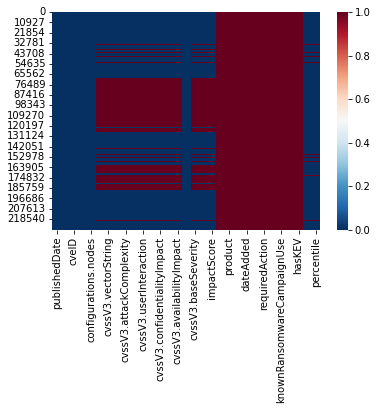

In [38]:
sns.heatmap(df.isnull(), cmap="RdBu_r")
plt.show()

In [39]:
df.columns = df.columns.map(lambda x: x.removeprefix('cvssV3.')) 
df.columns

Index(['publishedDate', 'lastModifiedDate', 'cveID', 'assigner',
       'configurations.nodes', 'version', 'vectorString', 'attackVector',
       'attackComplexity', 'privilegesRequired', 'userInteraction', 'scope',
       'confidentialityImpact', 'integrityImpact', 'availabilityImpact',
       'cvssScore', 'baseSeverity', 'exploitabilityScore', 'impactScore',
       'vendorProject', 'product', 'vulnerabilityName', 'dateAdded',
       'shortDescription', 'requiredAction', 'dueDate',
       'knownRansomwareCampaignUse', 'notes', 'hasKEV', 'epss', 'percentile'],
      dtype='object')

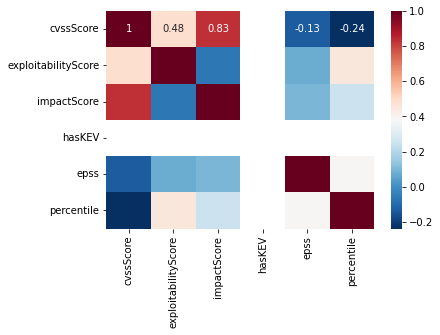

In [40]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu_r")
plt.show()

In [41]:
df.lastModifiedDate = pd.to_datetime(df.lastModifiedDate)
df.publishedDate = pd.to_datetime(df.publishedDate)
df.dueDate = pd.to_datetime(df.dueDate)

In [42]:
least_recent_date = df.publishedDate.min()
least_recent_date

Timestamp('1988-10-01 04:00:00+0000', tz='UTC')

In [43]:
most_recent_date = df.publishedDate.max()
most_recent_date

Timestamp('2023-11-02 06:15:00+0000', tz='UTC')

In [48]:
df['publishedYear'] = df['publishedDate'].apply(lambda x : x.year)

In [49]:
df['publishedMonth'] = df['publishedDate'].apply(lambda x : x.month)

In [50]:
z = df['publishedMonth'].value_counts()

z1 = z.to_dict() #converts to dictionary

df['count'] = df['publishedMonth'].map(z1)

In [51]:
df.tail(10)

,publishedDate,lastModifiedDate,cveID,assigner,configurations.nodes,version,vectorString,attackVector,attackComplexity,privilegesRequired,...,requiredAction,dueDate,knownRansomwareCampaignUse,notes,hasKEV,epss,percentile,publishedYear,publishedMonth,count
229443,2023-05-22 22:15:00+00:00,2023-05-30 18:05:00+00:00,CVE-2022-4945,ics-cert@hq.dhs.gov,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:C/C:H/I:N/A:N,LOCAL,LOW,LOW,...,NaN,NaT,NaN,NaN,NaN,0.00042,0.05852,2023,5,20926
229444,2023-06-05 14:15:00+00:00,2023-06-13 13:53:00+00:00,CVE-2022-4946,contact@wpscan.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,LOW,...,NaN,NaT,NaN,NaN,NaN,0.00045,0.12312,2023,6,18705
229445,2023-06-07 02:15:00+00:00,2023-06-13 18:38:00+00:00,CVE-2022-4948,cve-request@wordfence.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:N/I:L/A:N,NETWORK,LOW,LOW,...,NaN,NaT,NaN,NaN,NaN,0.00045,0.12312,2023,6,18705
229446,2023-06-07 02:15:00+00:00,2023-06-13 18:40:00+00:00,CVE-2022-4949,cve-request@wordfence.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,LOW,...,NaN,NaT,NaN,NaN,NaN,0.00260,0.63585,2023,6,18705
229447,2023-06-07 02:15:00+00:00,2023-06-13 18:42:00+00:00,CVE-2022-4950,cve-request@wordfence.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,LOW,...,NaN,NaT,NaN,NaN,NaN,0.00138,0.49123,2023,6,18705
229448,2023-07-17 02:15:00+00:00,2023-07-27 04:07:00+00:00,CVE-2022-4952,cna@vuldb.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,NETWORK,LOW,NONE,...,NaN,NaT,NaN,NaN,NaN,0.00052,0.18147,2023,7,19492
229449,2023-08-14 20:15:00+00:00,2023-09-08 23:15:00+00:00,CVE-2022-4953,contact@wpscan.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,NONE,...,NaN,NaT,NaN,NaN,NaN,0.00132,0.48078,2023,8,19627
229450,2023-10-20 07:15:00+00:00,2023-10-26 17:28:00+00:00,CVE-2022-4954,cve-request@wordfence.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:H/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,HIGH,...,NaN,NaT,NaN,NaN,NaN,0.00045,0.12312,2023,10,20703
229451,2023-08-04 20:15:00+00:00,2023-08-09 17:19:00+00:00,CVE-2022-4955,chrome-cve-admin@google.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:H/A:N,NETWORK,LOW,NONE,...,NaN,NaT,NaN,NaN,NaN,0.00048,0.15153,2023,8,19627
229452,2023-09-30 17:15:00+00:00,2023-10-03 20:58:00+00:00,CVE-2022-4956,cna@vuldb.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,LOCAL,LOW,LOW,...,NaN,NaT,NaN,NaN,NaN,0.00042,0.05714,2023,9,19525


In [52]:
df['epss'].fillna(0, inplace=True)

In [53]:
df['hasKEV'].fillna(0, inplace=True)

In [54]:
# save the dataframe to a new file
# df.to_csv('cve_epss_cvss.csv', index = False, encoding='utf-8-sig')

***
**RESTART HERE**
***

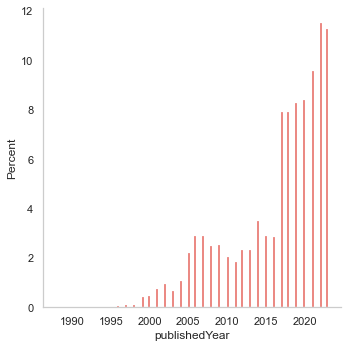

In [55]:
#define figure size
sns.set(rc={"figure.figsize":(20, 5)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("Spectral")
sns.displot(x= 'publishedYear', data=df, stat='percent')

<Axes: xlabel='publishedYear', ylabel='count'>

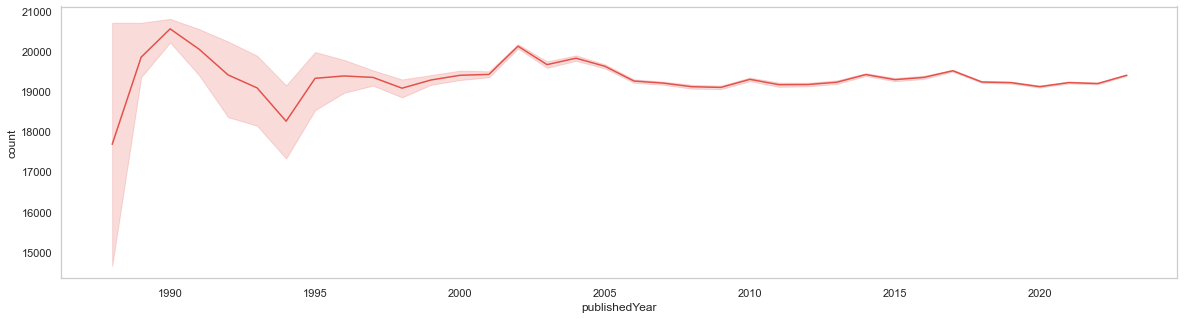

In [56]:
#define figure size
sns.set(rc={"figure.figsize":(20, 5)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("Spectral")
sns.lineplot('publishedYear', 'count', data=df)

In [57]:
cve_gr = pd.DataFrame({'count' : df.groupby( [ "publishedYear", "publishedMonth"] ).size()}).reset_index()

In [58]:
cve_gr['count'] = cve_gr['count'].replace(0, 1)

In [59]:
rolling = df.publishedDate.dt.to_period('M').sort_index().value_counts()

/var/folders/81/jyd7r7j97q36mxrppmmkm7qw0000gn/T/ipykernel_26796/2377251798.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  rolling = df.publishedDate.dt.to_period('M').sort_index().value_counts()


In [60]:
rolling.index = rolling.index.to_timestamp()
rolling = rolling.sort_index()
rolling[rolling.index] = np.cumsum(rolling.values)
rolling = rolling.rolling(12, axis=0).sum().pct_change(axis=0)

<Axes: >

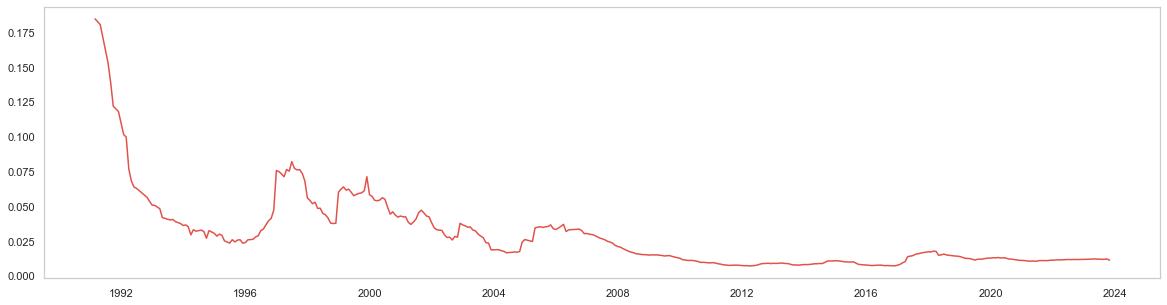

In [61]:
#define figure size
sns.set(rc={"figure.figsize":(20, 5)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("Spectral")
sns.lineplot(x=rolling.index, y=rolling.values)

In [62]:
y = df.cvssScore.sort_values().astype('int').value_counts().sort_index()[1:]

[Text(0, 0, '0.0%'),
 Text(0, 0, '0.4%'),
 Text(0, 0, '1.4%'),
 Text(0, 0, '7.3%'),
 Text(0, 0, '16.4%'),
 Text(0, 0, '17.1%'),
 Text(0, 0, '28.3%'),
 Text(0, 0, '13.7%'),
 Text(0, 0, '15.1%'),
 Text(0, 0, '0.2%')]

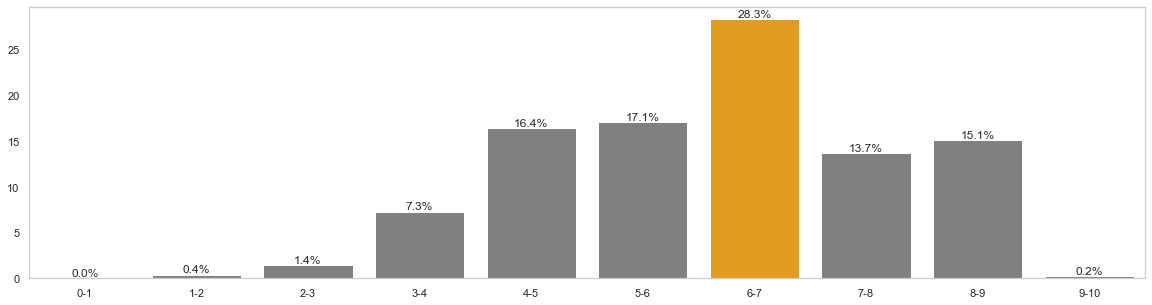

In [63]:
#define figure size
sns.set(rc={"figure.figsize":(20, 5)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("Spectral")
#use orange for bar with max value and grey for all other bars
cols = ['grey' if (x < max(y.values)) else 'orange' for x in y.values]

ax = sns.barplot(x=y.index.map(lambda x: "{}-{}".format(x-1,x)), y=y.values/np.sum(y.values)*100, palette=cols)
ax.bar_label(ax.containers[0], fmt='%.1f%%')

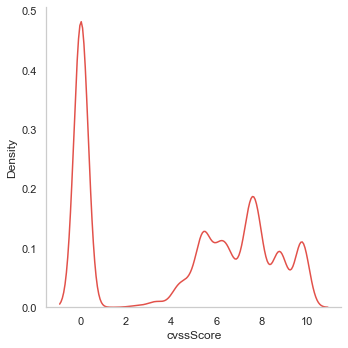

In [64]:
sns.displot(df, x="cvssScore", kind="kde")

In [65]:
y = df.epss.sort_values().astype('float').value_counts().sort_index()[1:]

In [66]:
df['epss'].describe()

count    229453.000000
mean          0.034193
std           0.144073
min           0.000000
25%           0.000540
50%           0.001270
75%           0.004930
max           0.975880
Name: epss, dtype: float64

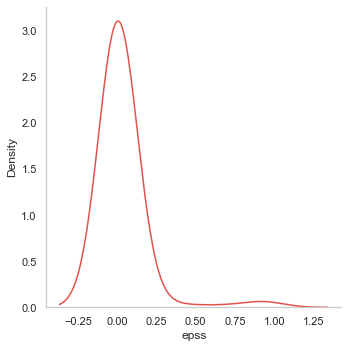

In [67]:
sns.displot(df, x="epss", kind="kde", bw_adjust=10)

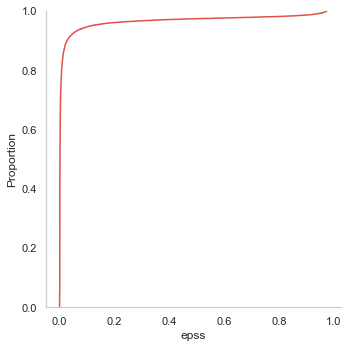

In [68]:
sns.displot(df, x="epss", kind="ecdf")

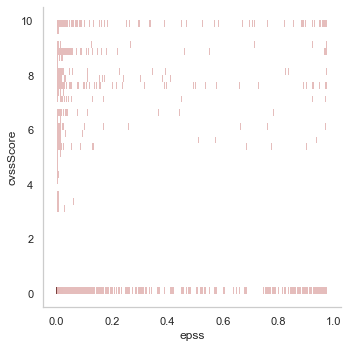

In [69]:
sns.displot(df, x="epss", y="cvssScore")

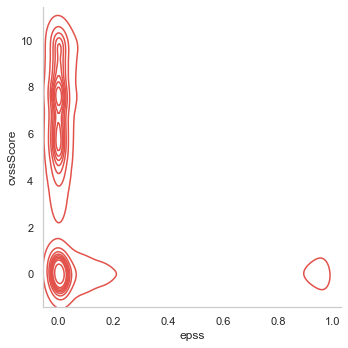

In [70]:
sns.displot(df, x="epss", y="cvssScore", kind="kde")

In [71]:
df.head(1)

,publishedDate,lastModifiedDate,cveID,assigner,configurations.nodes,version,vectorString,attackVector,attackComplexity,privilegesRequired,...,requiredAction,dueDate,knownRansomwareCampaignUse,notes,hasKEV,epss,percentile,publishedYear,publishedMonth,count
0,2021-06-09 20:15:00+00:00,2021-06-28 18:03:00+00:00,CVE-2021-0001,secure@intel.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:H/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,HIGH,LOW,...,NaN,NaT,NaN,NaN,0.0,0.00044,0.10634,2021,6,18705


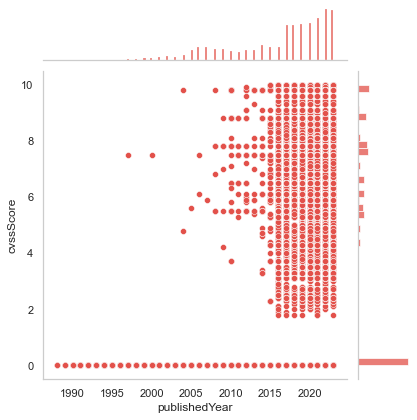

In [72]:
sns.jointplot(data=df, x="publishedYear", y="cvssScore")

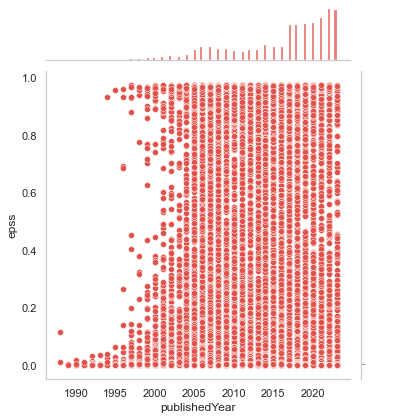

In [73]:
sns.jointplot(data=df, x="publishedYear", y="epss")

In [74]:
def venn_diagram(a, b, c, labels):

    a = set(a)
    b = set(b)
    c = set(c)

    only_a = len(a - b - c)
    only_b = len(b - a - c)
    only_c = len(c - a - b)

    only_a_b = len(a & b - c)
    only_a_c = len(a & c - b)
    only_b_c = len(b & c - a)

    a_b_c = len(a & b & c)

    venn3(subsets=(only_a, only_b, only_a_b, only_c, only_a_c, only_b_c, a_b_c), set_labels=labels,
         set_colors=("lightblue", "darkred", "grey"), alpha=0.8)

In [75]:
a = kev.cveID
b = cvss.cveID[cvss.cvssScore >= 7]
c = epss.cveID
labels = ['Present in KEV', 'CVSS7+', 'EPSS']

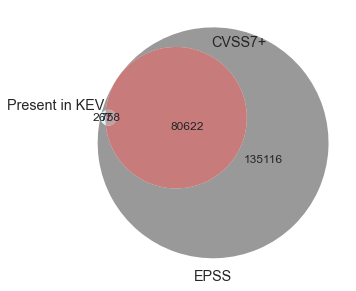

In [76]:
venn_diagram(a, b, c, labels)

In [77]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [78]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(cvss) * 100))

Patching effort: 35.47%


In [79]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

Efficiency: 0.93%


In [80]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

Coverage: 100.00%


In [81]:
a = kev.cveID
b = cvss.cveID
c = epss.cveID[epss.epss > 0.5]
labels = ['Present in KEV', 'CVSS', 'EPSS 0.5+']

In [82]:
sets = [set(a), set(b), set(c)]
# supervenn(sets, labels, side_plots=False, widths_minmax_ratio=0.05, min_width_for_annotation=100)

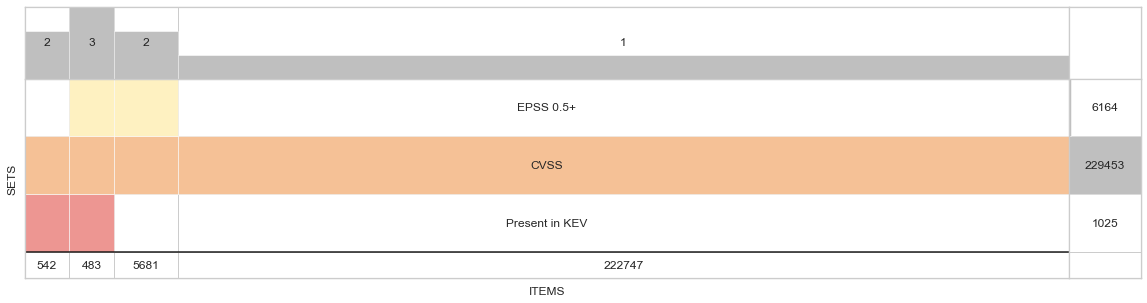

In [83]:
supervenn(sets, labels, widths_minmax_ratio=0.05, min_width_for_annotation=100)

In [84]:
a = kev.cveID
b = cvss.cveID
c = epss.cveID[epss.epss > 0.1]
labels = ['Present in KEV', 'CVSS', 'EPSS 0.1+']

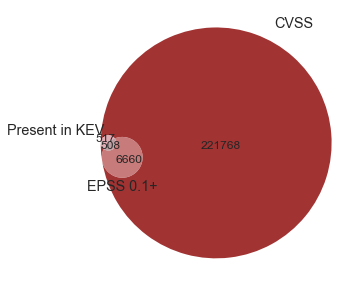

In [85]:
venn_diagram(a, b, c, labels)

In [86]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [87]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(cvss) * 100))

Patching effort: 3.12%


In [88]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

Efficiency: 7.09%


In [89]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

Coverage: 49.56%


In [90]:
import cve_searchsploit as CS

In [91]:
CS.update_db()

Refreshing exploit-database repo with latest exploits


From https://gitlab.com/exploit-database/exploitdb
 * branch                main       -> FETCH_HEAD
100% (46256 of 46256) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


Already up to date.
Refreshing EDBID-CVE mapping


In [92]:
CS.edbid_from_cve("CVE-2019-0708")

[46946, 47120, 47120, 47416, 47416, 47683]

In [93]:
df.hasKEV.describe()

count    229453.000000
mean          0.004467
std           0.066687
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: hasKEV, dtype: float64

In [94]:
# df['hasKEV'] = df.apply(lambda row: row['hasKEV'] if len(CS.edbid_from_cve(row['cveID'])) == 0 else 1, axis=1)
# condition = df['cveID'].apply(lambda x: len(CS.edbid_from_cve(x)) == 0)
# condition = [len(CS.edbid_from_cve(x)) == 0 for x in df['cveID']]

In [97]:
condition = np.vectorize(lambda x: len(CS.edbid_from_cve(x)) == 0)(df['cveID'])

In [98]:
df['hasKEV'] = np.where(condition, df['hasKEV'], 1)

In [99]:
df.hasKEV.describe()

count    229453.000000
mean          0.109783
std           0.312620
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: hasKEV, dtype: float64

In [100]:
# save the dataframe to a new file
df.to_csv('cve_epss_cvss.csv', index = False, encoding='utf-8-sig')

In [120]:
a = df.loc[df['hasKEV'] == 1, 'cveID']
b = df.loc[df['cvssScore'] >= 7, 'cveID']
c = df.cveID
labels = ['Present in KEV', 'CVSS7+', 'EPSS']

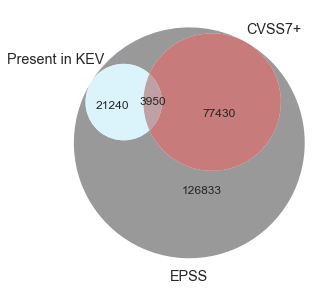

In [121]:
venn_diagram(a, b, c, labels)

In [122]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [123]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(cvss) * 100))

Patching effort: 35.47%


In [124]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

Efficiency: 4.85%


In [125]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

Coverage: 100.00%


In [140]:
a = df.loc[df['hasKEV'] == 1, 'cveID']
b = df.cveID
c = df.loc[df['epss'] > 0.1, 'cveID']


labels = ['Present in KEV', 'CVSS', 'EPSS 0.1+']

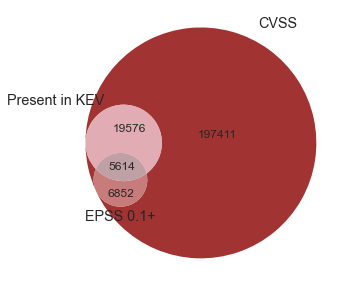

In [141]:
venn_diagram(a, b, c, labels)

In [142]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [143]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(cvss) * 100))

Patching effort: 5.43%


In [144]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

Efficiency: 45.03%


In [145]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

Coverage: 22.29%


In [146]:
a = df.loc[df['hasKEV'] == 1, 'cveID']
b = df.cveID
c = df.loc[df['epss'] >= 0.36, 'cveID']


labels = ['Present in KEV', 'CVSS', 'EPSS 0.36+']

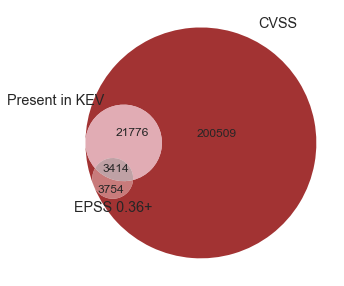

In [147]:
venn_diagram(a, b, c, labels)

In [148]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [149]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(cvss) * 100))

Patching effort: 3.12%


In [150]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

Efficiency: 47.63%


In [151]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

Coverage: 13.55%
